# Multiclass classification
- class가 여러개인 경우에 대한 classification example
- 아래에도 적어두었지만 feature를 늘리고 layer를 늘린다고 더 잘되리란 법 없고, 오히려 완전 망할 수도 있다
    - 따라서 실험도 꽤 해봐야 하고, normalization같은 것도 해봐야 한다

type(X) = <class 'numpy.ndarray'>
X.shape = (2000, 2)
y.shape = (2000,)


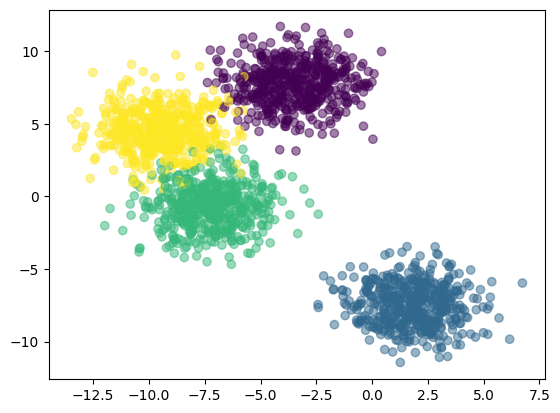

X[:5] = 
tensor([[ -8.8136,   3.9135],
        [ -3.0493,   5.9282],
        [  1.6706, -10.0053],
        [ -8.8553,   3.7744],
        [ -9.1738,   2.9924]])
y[:5] = 
tensor([3, 0, 1, 3, 3])


In [93]:
# 1. import 및 데이터 생성 (앞과 동일)

import matplotlib.pyplot
import numpy
import torch
import sklearn.datasets
import sklearn.model_selection

device = 'cuda' if torch.cuda.is_available() else 'cpu'
n = 2000

# hyperparameter for data creation
num_class = 4
num_feature = 2
rand_seed = 2023 # random seed를 안정하면 돌릴때 마다 너무 차이나서 이번엔 고정

X,y = sklearn.datasets.make_blobs(
    n_samples=2000, centers=num_class, n_features=num_feature, 
    cluster_std = 1.5, # 이 숫자가 커지면 클러스터가 퍼지는 정도가 커진다
    random_state=rand_seed
)

print(f'type(X) = {type(X)}')
print(f'X.shape = {X.shape}') # 점의 좌표 
print(f'y.shape = {y.shape}') # 각 점의 class (0 or 1)

# visualize
matplotlib.pyplot.scatter(X[:,0], X[:,1], c=y, alpha=0.5) # c가 0/1의 array이면 색깔이 다르게 지정되는게 편리하다
matplotlib.pyplot.show()

# ndarray -> Tensor + train-test split
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.LongTensor) # class가 0,1,2,3 이므로 LongTensor. float면 확률이라고 생각해서 에러가 나옴

print(f'X[:5] = \n{X[:5]}')
print(f'y[:5] = \n{y[:5]}')

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2)

In [94]:
# Function은 모두 똑같이 사용한다

# define metric
def metric_accuracy(y_true, y_pred):
    num_correct = torch.eq(y_true, y_pred).sum().item() # sum()은 0차원의 tensor를 반환하므로 item()을 통해 scalar로 변환
    accuracy = num_correct / len(y_true)
    return accuracy

# define training function
def train_multiclass(X_train, y_train, X_test, y_test, epoch_cnt, model, optimizer, loss_func):
    X_train_prev_device = X_train.device
    y_train_prev_device = y_train.device
    X_test_prev_device = X_test.device
    y_test_prev_device = y_test.device

    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    model.train() # train mode로 전환
    batch_size = 32
    for e in range(epoch_cnt):
        # batch size를 32로 설정한다
        for b in range(0, len(X_train), batch_size):
            X_batch = X_train[b:b+batch_size]
            y_batch = y_train[b:b+batch_size]

            # 1. forward pass 실행
            y_logit = model(X_batch)
            
            # 2. loss 계산
            loss = loss_func(y_logit, y_batch) 

            # 3. gradient 초기화. 이걸 안하면 gradient가 누적된다고 한다
            optimizer.zero_grad()
            # 4. 각 요소의 gradient contribution을 계산한다 
            loss.backward() 
            # 5. gradient descent를 실제 실행한다
            optimizer.step() 

        if e % 10 == 0:
            model.eval() # model을 evaluation mode로 설정한다
            with torch.inference_mode():
                y_pred_test_logit = model(X_test)
                test_loss = loss_func(y_pred_test_logit, y_test)

                y_pred_test = torch.argmax(y_pred_test_logit, dim=1)
                test_acc = metric_accuracy(y_test, y_pred_test)

                print(f'Epoch {e}: test_loss: {test_loss:.2f}    test_acc: {test_acc:.2f}')

            model.train() # model을 training mode로 원상 복구
    
    X_train = X_train.to(X_train_prev_device)
    y_train = y_train.to(y_train_prev_device)
    X_test = X_test.to(X_test_prev_device)
    y_test = y_test.to(y_test_prev_device)

# decision boundary function

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor, resolution = 1000):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

    # linspace(start, stop, num) -> Return evenly spaced numbers over a specified interval.
    # meshgrid(x, y) -> Return coordinate matrices from coordinate vectors.
    xx, yy = numpy.meshgrid(numpy.linspace(x_min, x_max, resolution + 1), numpy.linspace(y_min, y_max, resolution + 1))

    # Make features
    # ravel() -> Return a contiguous flattened array.
    X_to_pred_on = torch.from_numpy(numpy.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    matplotlib.pyplot.contourf(xx, yy, y_pred, cmap=matplotlib.pyplot.cm.RdYlBu, alpha=0.7)
    matplotlib.pyplot.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=matplotlib.pyplot.cm.RdYlBu, alpha=0.5)
    matplotlib.pyplot.xlim(xx.min(), xx.max())
    matplotlib.pyplot.ylim(yy.min(), yy.max())

In [95]:
# model definition

class MultiClassClassifier(torch.nn.Module):
    def __init__(self, input_features, output_features, hidden_units, hidden_layers):
        super().__init__()

        layers = [
            torch.nn.Linear(input_features, hidden_units),
            torch.nn.ReLU()
        ]
        for _ in range(hidden_layers):
            layers.append(torch.nn.Linear(hidden_units, hidden_units))
            layers.append(torch.nn.ReLU())

        layers.append(torch.nn.Linear(hidden_units, output_features))
        layers.append(torch.nn.Softmax(dim=1))

        self.layer_seq = torch.nn.Sequential(*layers)

    def forward(self, X):
        return self.layer_seq(X)

Epoch 0: test_loss: 0.83    test_acc: 0.97
Epoch 10: test_loss: 0.77    test_acc: 0.97
Epoch 20: test_loss: 0.77    test_acc: 0.97
Epoch 30: test_loss: 0.78    test_acc: 0.96
Epoch 40: test_loss: 0.76    test_acc: 0.99
Epoch 50: test_loss: 0.76    test_acc: 0.98
Epoch 60: test_loss: 0.76    test_acc: 0.99
Epoch 70: test_loss: 0.78    test_acc: 0.96
Epoch 80: test_loss: 0.77    test_acc: 0.97
Epoch 90: test_loss: 0.76    test_acc: 0.98


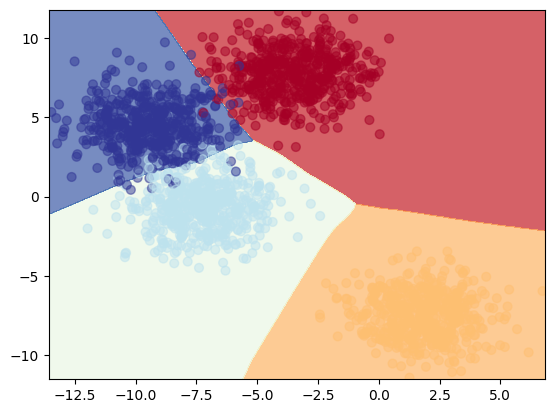

In [96]:
# create model instance
model = MultiClassClassifier( # 처음엔 hidden layer 없이 해보자
    input_features=num_feature, output_features=num_class, hidden_units=20, hidden_layers=1).to(device)

# define optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

# define loss function
loss_func = torch.nn.CrossEntropyLoss()

# train
train_multiclass(X_train, y_train, X_test, y_test, 100, model, optimizer, loss_func)
plot_decision_boundary(model, X, y)

Epoch 0: test_loss: 1.25    test_acc: 0.49
Epoch 10: test_loss: 1.25    test_acc: 0.49
Epoch 20: test_loss: 1.25    test_acc: 0.49
Epoch 30: test_loss: 1.25    test_acc: 0.49
Epoch 40: test_loss: 1.25    test_acc: 0.49
Epoch 50: test_loss: 1.25    test_acc: 0.49
Epoch 60: test_loss: 1.25    test_acc: 0.49
Epoch 70: test_loss: 1.25    test_acc: 0.49
Epoch 80: test_loss: 1.25    test_acc: 0.49
Epoch 90: test_loss: 1.25    test_acc: 0.49


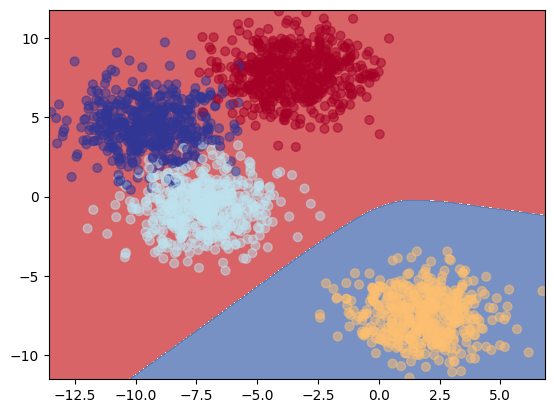

In [97]:
# 의외로 hidden layer를 늘린다고 해서 더 잘되지 않는다.

# create model instance
model = MultiClassClassifier( # 처음엔 hidden layer 없이 해보자
    input_features=num_feature, output_features=num_class, hidden_units=100, hidden_layers=2).to(device)

# define optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.1)

# define loss function
loss_func = torch.nn.CrossEntropyLoss()

# train
train_multiclass(X_train, y_train, X_test, y_test, 100, model, optimizer, loss_func)
plot_decision_boundary(model, X, y)